In [1]:
import pandas as pd
import numpy as np 
import os 



In [2]:
from sagemaker.session import Session,get_execution_role


In [3]:
sagemaker_session = Session()
bucket = sagemaker_session.default_bucket()
role = get_execution_role()

In [4]:
from helper import parse_date, process_text, csv_to_s3


## Data Exploration and Cleaning

In [5]:
true = pd.read_csv("data/True.csv")
fake = pd.read_csv("data/Fake.csv")

In [6]:
true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [7]:
fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

This is the kind of data I will be working with. First things to note down:
* title and text columns must be correctly cleaned before use 
* I will inspect the unique values in true and fake 'subject' column
* date is in a wrong format; I will convert it as it may be useful during feature engineering, fake news tend to grow much in delicate instants for political and international facts. 

Data length and types:

In [8]:
true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
title      21417 non-null object
text       21417 non-null object
subject    21417 non-null object
date       21417 non-null object
dtypes: object(4)
memory usage: 669.4+ KB


In [9]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
title      23481 non-null object
text       23481 non-null object
subject    23481 non-null object
date       23481 non-null object
dtypes: object(4)
memory usage: 733.9+ KB


Now, some visualizations to see distribution of 'subject' variable. Which is the most common subject for those who write fake news? Politics?

In [10]:
import matplotlib.pyplot as plt 

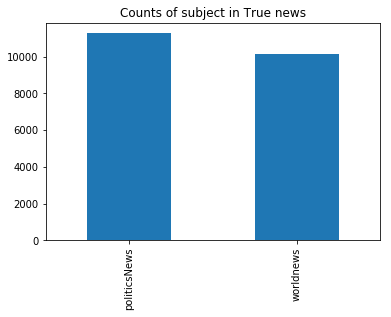

In [11]:
true['subject'].value_counts().plot(kind='bar', title='Counts of subject in True news')

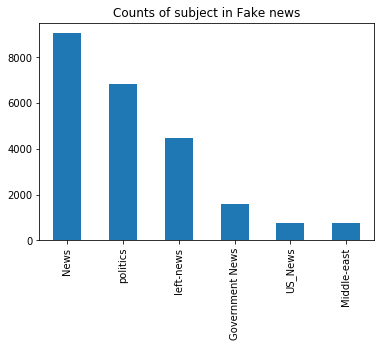

In [12]:
fake['subject'].value_counts().plot(kind='bar', title='Counts of subject in Fake news')

Subjects are mapped differently between True and Fake news as they're numerous in the latter, so I might think of remapping all of the subject of Fake dataset into either politicsNews or worldnews classes to have homogeneity.

First of all, I'd have to give a look at a couple of news mapped as 'left-news' in the fake dataset, as I don't have clear what it refers to.§

In [13]:
fake[fake['subject']=='left-news']['text'].iloc[0]

"Barbra Streisand was an Obama sycophant and one of the corrupt Clinton s most loyal fans. She is also part of the Hollywood liberal  resistance  movement. Much like Rosie O Donnell, Kathy Griffin, and literally hundreds of overpaid celebrities, Barbara Streisand is obsessed with tweeting about how much she hates President Trump. It s Streisand s latest tweet that has conservatives calling her out for her complete and utter  stupidity .Streisand tweeted: Collusion or no collusion, @realDonaldTrump should be impeached for sheer stupidity. Collusion or no collusion, @realDonaldTrump should be impeached for sheer stupidity.  Barbra Streisand (@BarbraStreisand) December 30, 2017Twitter users wasted no time DESTROYING the  has been  entertainer.This tweet suggested her music and acting awards should be recalled due to the  sheer stupidity  of the recipient.I can think of a lot of Oscars, Emmy s, Tony s and Grammy s that should be recalled due to sheer stupidity of the recipient. Particularl

Ok so it refers to fake news made up to discredit left-oriented thinkers, specifically.

Now I can create a single DataFrame consisting of both True and Fake news to apply consistent preparation and cleaning. Before concatenating the two, I'll create the 'class' column, which will be valued 0 for True and 1 for Fake.

In [14]:
true['targetClass'] = 0
fake['targetClass'] = 1

In [15]:
df = pd.concat([true,fake])

In [16]:
#Shuffle the dataframe to randomize things up
df=df.sample(frac=1, random_state=1).reset_index(drop=True)

In [17]:
df.head(10)

title  \
0  EPA chief says Paris climate agreement 'bad de...   
1  BREAKING NEWS: President Trump Announces Major...   
2  Trump says New Hampshire win not necessary to ...   
3  Kremlin: U.S. sanctions aimed at turning busin...   
4  MUST WATCH: Kellyanne Conway PUNCHES BACK Afte...   
5  Poland's PM designate says will continue fight...   
6  One more Republican defection would doom Senat...   
7  IT BEGINS: ANTHONY SCARAMUCCI FIRES Suspected ...   
8  Refugee Living In England Arrested For Threate...   
9   Cory Booker EVISCERATES RNC’s Hateful Tone, ‘...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The United States shoul...  politicsNews   
1  President Trump just tweeted out a new policy ...      politics   
2  WASHINGTON (Reuters) - U.S. Republican preside...  politicsNews   
3  MOSCOW (Reuters) - The Kremlin said on Thursda...     worldnews   
4  Kellyanne Conway s response to Williams  criti...     left-news   
5  WARSAW (Reuters) - Poland will continue fighti...     worldnews   
6  WASHINGTON (Reuters) - President Donald Trump ...  politicsNews   
7  Scaramucci promised the heads of White House l...      politics   
8  Here is just one more, in a long line of stori...     left-news   
9  Senator Cory Booker was none too happy with wh...          News   

                 date  targetClass  
0      April 2, 2017             0  
1        Jul 26, 2017            1  
2   February 7, 2016             0  
3  November 30, 2017             0  
4        Dec 27, 2016            1  
5   December 8, 2017             0  
6      July 14, 2017             0  
7        Jul 25, 2017            1  
8        Jan 27, 2016            1  
9       July 23, 2016            1

To parse this date column, I'll make use of the Python's dateutil package. 

In [18]:
from dateutil import parser

In [19]:
df['date'] = df['date'].apply(parser.parse)

ValueError: ('Unknown string format:', 'https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/')

I found this ValueError because apparently there is some sort of data quality issue in the 'date' column. 

I'll define a function with a try-except block in order to parse all the parseable and set nan to the rest to see how much invalid entries there are.

In [20]:
df['date'] = df['date'].apply(parse_date)

In [21]:
df['date'].head()

0   2017-04-02
1   2017-07-26
2   2016-02-07
3   2017-11-30
4   2016-12-27
Name: date, dtype: datetime64[ns]

It has worked, but I want to check how many rows are nan.

In [22]:
df[df.isna().any(axis=1)]

title  \
6296   https://100percentfedup.com/video-hillary-aske...   
12423  https://fedup.wpengine.com/wp-content/uploads/...   
15240  https://fedup.wpengine.com/wp-content/uploads/...   
17057  https://fedup.wpengine.com/wp-content/uploads/...   
22156  https://100percentfedup.com/12-yr-old-black-co...   
24481  https://fedup.wpengine.com/wp-content/uploads/...   
27329  https://fedup.wpengine.com/wp-content/uploads/...   
28062  https://fedup.wpengine.com/wp-content/uploads/...   
41313                                           Homepage   
44705  https://100percentfedup.com/served-roy-moore-v...   

                                                    text          subject  \
6296   https://100percentfedup.com/video-hillary-aske...         politics   
12423  https://fedup.wpengine.com/wp-content/uploads/...  Government News   
15240  https://fedup.wpengine.com/wp-content/uploads/...         politics   
17057  https://fedup.wpengine.com/wp-content/uploads/...        left-news   
22156  https://100percentfedup.com/12-yr-old-black-co...         politics   
24481  https://fedup.wpengine.com/wp-content/uploads/...  Government News   
27329  https://fedup.wpengine.com/wp-content/uploads/...         politics   
28062  https://fedup.wpengine.com/wp-content/uploads/...        left-news   
41313  [vc_row][vc_column width= 1/1 ][td_block_trend...        left-news   
44705  https://100percentfedup.com/served-roy-moore-v...         politics   

      date  targetClass  
6296   NaT            1  
12423  NaT            1  
15240  NaT            1  
17057  NaT            1  
22156  NaT            1  
24481  NaT            1  
27329  NaT            1  
28062  NaT            1  
41313  NaT            1  
44705  NaT            1

Perfect, as they are only ~ 10 rows I can easily drop them, the curious thing is that they all belong to the fake class.

In [23]:
df.dropna(inplace=True)

In [24]:
len(df)

44888

In [26]:
df['targetClass'].value_counts()/len(df)

1    0.522879
0    0.477121
Name: targetClass, dtype: float64

Perfect, so the target is well-balanced. I will now perform the mapping of the 'subject' column as I said before.

In [27]:
df['subject'].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6836
left-news           4456
Government News     1568
US_News              783
Middle-east          778
Name: subject, dtype: int64

* politicsNew,politics,left-news,government News -> politics

* worldnews, news, US_News, Middle-east -> general

In [28]:
#Create a single view of multiple mappings
from collections import ChainMap
to_politics = ["politicsNews","left-news","Government News","politics"]
to_general = ["worldnews", "News","US_News", "Middle-east"]
full_map = ChainMap(dict.fromkeys(to_politics,'politics'),dict.fromkeys(to_general,'general'))

In [29]:
df['subject'] = df['subject'].map(full_map.get)

In [30]:
df['subject'].value_counts()

politics    24132
general     20756
Name: subject, dtype: int64

In [31]:
df.head()

title  \
0  EPA chief says Paris climate agreement 'bad de...   
1  BREAKING NEWS: President Trump Announces Major...   
2  Trump says New Hampshire win not necessary to ...   
3  Kremlin: U.S. sanctions aimed at turning busin...   
4  MUST WATCH: Kellyanne Conway PUNCHES BACK Afte...   

                                                text   subject       date  \
0  WASHINGTON (Reuters) - The United States shoul...  politics 2017-04-02   
1  President Trump just tweeted out a new policy ...  politics 2017-07-26   
2  WASHINGTON (Reuters) - U.S. Republican preside...  politics 2016-02-07   
3  MOSCOW (Reuters) - The Kremlin said on Thursda...   general 2017-11-30   
4  Kellyanne Conway s response to Williams  criti...  politics 2016-12-27   

   targetClass  
0            0  
1            1  
2            0  
3            0  
4            1

In [32]:
!pip install tqdm
from tqdm import tqdm

     |████████████████████████████████| 61kB 1.8MB/s  eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [36]:
'''df.at[index,'textLength']'''
for index, row in tqdm( df.iterrows(), total=df.shape[0]):
    
    df.at[index,'cleanedText'] = process_text(row['text'], length=False,stem=False)
    df.at[index,'cleanedTitle']= process_text(row['title'],stem=False)

100%|██████████| 44888/44888 [00:33<00:00, 1324.46it/s]


In [37]:
df.head()

title  \
0  EPA chief says Paris climate agreement 'bad de...   
1  BREAKING NEWS: President Trump Announces Major...   
2  Trump says New Hampshire win not necessary to ...   
3  Kremlin: U.S. sanctions aimed at turning busin...   
4  MUST WATCH: Kellyanne Conway PUNCHES BACK Afte...   

                                                text   subject       date  \
0  WASHINGTON (Reuters) - The United States shoul...  politics 2017-04-02   
1  President Trump just tweeted out a new policy ...  politics 2017-07-26   
2  WASHINGTON (Reuters) - U.S. Republican preside...  politics 2016-02-07   
3  MOSCOW (Reuters) - The Kremlin said on Thursda...   general 2017-11-30   
4  Kellyanne Conway s response to Williams  criti...  politics 2016-12-27   

   targetClass                                        cleanedText  textLength  \
0            0  washington the united states continue internat...       206.0   
1            1  president trump tweeted new policy us military...        57.0   
2            0  washington republican presidential candidate d...       158.0   
3            0  moscow the kremlin said thursday confident uni...        44.0   
4            1  kellyanne conway response williams criticism c...         8.0   

                                        cleanedTitle  
0             epa chief says paris climate agreement  
1  breaking president trump announces major polic...  
2  trump says new hampshire win necessary secure ...  
3       sanctions aimed turning business elite putin  
4  must kellyanne conway punches back after juan ...

In [38]:
cleaned_df = df[['cleanedText','cleanedTitle','targetClass']].copy()

In [39]:
cleaned_df.head()

cleanedText  \
0  washington the united states continue internat...   
1  president trump tweeted new policy us military...   
2  washington republican presidential candidate d...   
3  moscow the kremlin said thursday confident uni...   
4  kellyanne conway response williams criticism c...   

                                        cleanedTitle  targetClass  
0             epa chief says paris climate agreement            0  
1  breaking president trump announces major polic...            1  
2  trump says new hampshire win necessary secure ...            0  
3       sanctions aimed turning business elite putin            0  
4  must kellyanne conway punches back after juan ...            1

Now, I will extract some features from the date column: 
* weekofyear,dayofweek,dayofyear, quarter
* is_month_start,is_month_end,is_year_start, is_year_end

In [ ]:
cleaned_df['weekOfYear'] = cleaned_df['date'].dt.weekofyear
cleaned_df['dayOfWeek'] = cleaned_df['date'].dt.dayofweek
cleaned_df['dayOfYear'] = cleaned_df['date'].dt.dayofyear
cleaned_df['quarter'] =  cleaned_df['date'].dt.quarter
cleaned_df['isMonthStart'] = cleaned_df['date'].dt.is_month_start
cleaned_df['isMonthEnd'] = cleaned_df['date'].dt.is_month_end
cleaned_df['isYearStart'] = cleaned_df['date'].dt.is_year_start
cleaned_df['isYearEnd'] = cleaned_df['date'].dt.is_year_end

In [ ]:
cleaned_df.head()

In [ ]:
cleaned_df.to_csv('cleaned_data.csv')

In [ ]:
cleaned_df['subject']=cleaned_df['subject'].map({"general":0, "politics":1})

In [ ]:
for var in filter(lambda x: x.startswith('is'), cleaned_df.columns):

    cleaned_df[var] = cleaned_df[var].astype('int')

In [ ]:
cleaned_df.drop('date',axis=1,inplace=True)

In [ ]:
#Add vectorizers

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect_text = TfidfVectorizer(max_features=2500).fit(cleaned_df['cleanedText'])
vect_title=TfidfVectorizer(max_features=250).fit(cleaned_df['cleanedTitle'])


In [ ]:
text_df = pd.DataFrame(vect_text.transform(cleaned_df['cleanedText']).toarray().astype(np.float16), columns=vect_text.get_feature_names())
title_df = pd.DataFrame(vect_title.transform(cleaned_df['cleanedTitle']).toarray().astype(np.float16), columns=vect_title.get_feature_names())

In [ ]:
cleaned_df.rename(columns={"subject":"textSubject", "class":"textClass","quarter":"yearQuarter"}, inplace=True)

In [ ]:
full_df = pd.concat([cleaned_df,text_df,title_df],axis=1)

In [ ]:
full_df.head(1)

In [ ]:
full_df.drop(['cleanedText','cleanedTitle'],axis=1,inplace=True)

In [ ]:
full_df.head(1)

In [40]:
y = cleaned_df['targetClass']
X = cleaned_df.drop('targetClass',axis=1)

In [42]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y, random_state=1, stratify=y, test_size=0.3)

I am ready to save the data on S3.

In [44]:
path='data/text'
prefix='udacityCapstone/data'

In [45]:
pd.concat([y_train,X_train],axis=1).to_csv(path+'_train.csv',index=False,header=False)

In [46]:
pd.concat([y_test,X_test],axis=1).to_csv(path+'_test.csv',index=False,header=False)

In [48]:
sagemaker_session.upload_data(bucket=bucket, key_prefix=prefix, path=path+'_train.csv')
sagemaker_session.upload_data(bucket=bucket, key_prefix=prefix, path=path+'_test.csv')

's3://sagemaker-eu-central-1-126514844793/udacityCapstone/data/text_test.csv'